# Implementation of ConvNeXt: A ConvNet for the 2020s

This notebook implements the ConvNeXt architecture as described in the paper "A ConvNet for the 2020s" by Liu et al. ConvNeXt is a pure convolutional neural network architecture designed to match or exceed the performance of Vision Transformers while maintaining the simplicity and efficiency of traditional ConvNets.

## Table of Contents

1. [Introduction]
2. [Setup and Imports]
3. [Architecture Implementation]
4. [Dataset Preparation]
5. [Training Setup]
6. [Model Training]
7. [Model Evaluation]
8. [Performance Analysis]
9. [Conclusion and Next Steps]

## 1. Introduction

The paper "A ConvNet for the 2020s" explores the design space of convolutional neural networks by gradually "modernizing" a standard ResNet toward the design of a vision Transformer. The authors discover several key components that contribute to the performance difference along the way, resulting in the ConvNeXt architecture.

Key innovations of ConvNeXt include:

- Replacing the traditional stem with a "patchify" layer (4×4 non-overlapping convolution)
- Using depthwise convolutions with larger kernel sizes (7×7)
- Adopting an inverted bottleneck design
- Reducing the number of activation functions and normalization layers
- Substituting BatchNorm with LayerNorm
- Adding separate downsampling layers between stages

These modifications allow ConvNeXt to achieve performance comparable to or better than Swin Transformers across various vision tasks while maintaining the simplicity of standard ConvNets.

## 2. Setup and Imports

Let's start by installing and importing the necessary packages:

In [52]:
# Install packages (if needed)
# !pip install torch torchvision timm matplotlib numpy pandas seaborn tqdm ipywidgets

In [53]:
import os
import math
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from timm.models.layers import trunc_normal_, DropPath
from timm.data.transforms import RandomResizedCropAndInterpolation
from timm.data.mixup import Mixup
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy
from tqdm.notebook import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 3. Architecture Implementation

Now, let's implement the core components of the ConvNeXt architecture:

### 3.1 LayerNorm Implementation

The ConvNeXt architecture uses LayerNorm instead of BatchNorm, with support for both channels_last and channels_first formats:

In [54]:
class LayerNorm(nn.Module):
    """
    LayerNorm that supports two data formats: channels_last (default) or channels_first.
    channels_last = (batch_size, height, width, channels)
    channels_first = (batch_size, channels, height, width)
    """
    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError
        self.normalized_shape = (normalized_shape, )
    
    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]
            return x

### 3.2 ConvNeXt Block Implementation

The ConvNeXt Block is the fundamental building block of the architecture:

In [55]:
class Block(nn.Module):
    """
    ConvNeXt Block. There are two equivalent implementations:
    (1) DwConv -> LayerNorm (channels_first) -> 1x1 Conv -> GELU -> 1x1 Conv; all in (N, C, H, W)
    (2) DwConv -> Permute to (N, H, W, C); LayerNorm (channels_last) -> Linear -> GELU -> Linear; Permute back
    
    We use (2) as it's slightly faster in PyTorch.
    """
    def __init__(self, dim, drop_path=0., layer_scale_init_value=1e-6):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim)  # depthwise conv
        self.norm = LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, 4 * dim)  # pointwise/1x1 convs, implemented with linear layers
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim)
        self.gamma = nn.Parameter(layer_scale_init_value * torch.ones((dim)), 
                                requires_grad=True) if layer_scale_init_value > 0 else None
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1)  # (N, C, H, W) -> (N, H, W, C)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        if self.gamma is not None:
            x = self.gamma * x
        x = x.permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)

        x = input + self.drop_path(x)
        return x

### 3.3 ConvNeXt Architecture Implementation

Now, let's implement the complete ConvNeXt architecture:

In [56]:
class ConvNeXt(nn.Module):
    """
    ConvNeXt
    A PyTorch implementation of: "A ConvNet for the 2020s" - https://arxiv.org/pdf/2201.03545.pdf
    """
    def __init__(self, in_chans=3, num_classes=1000, 
                 depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], drop_path_rate=0., 
                 layer_scale_init_value=1e-6, head_init_scale=1.):
        super().__init__()

        # Stem layer - "patchify" the image
        self.downsample_layers = nn.ModuleList()
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=4),
            LayerNorm(dims[0], eps=1e-6, data_format="channels_first")
        )
        self.downsample_layers.append(stem)
        
        # Downsampling layers between stages
        for i in range(3):
            downsample_layer = nn.Sequential(
                    LayerNorm(dims[i], eps=1e-6, data_format="channels_first"),
                    nn.Conv2d(dims[i], dims[i+1], kernel_size=2, stride=2),
            )
            self.downsample_layers.append(downsample_layer)

        # Four stages, each with multiple ConvNeXt blocks
        self.stages = nn.ModuleList()
        dp_rates = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))] 
        cur = 0
        for i in range(4):
            stage = nn.Sequential(
                *[Block(dim=dims[i], drop_path=dp_rates[cur + j], 
                layer_scale_init_value=layer_scale_init_value) for j in range(depths[i])]
            )
            self.stages.append(stage)
            cur += depths[i]

        # Final norm layer, pooling and classifier
        self.norm = nn.LayerNorm(dims[-1], eps=1e-6)  # final norm layer
        self.head = nn.Linear(dims[-1], num_classes)

        # Initialize weights
        self.apply(self._init_weights)
        self.head.weight.data.mul_(head_init_scale)
        self.head.bias.data.mul_(head_init_scale)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            trunc_normal_(m.weight, std=.02)
            nn.init.constant_(m.bias, 0)

    def forward_features(self, x):
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
        return self.norm(x.mean([-2, -1]))  # global average pooling, (N, C, H, W) -> (N, C)

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

### 3.4 ConvNeXt Variants

Let's implement functions to create different variants of ConvNeXt:

In [57]:
def convnext_tiny(num_classes=1000, **kwargs):
    model = ConvNeXt(depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], num_classes=num_classes, **kwargs)
    return model

def convnext_small(num_classes=1000, **kwargs):
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[96, 192, 384, 768], num_classes=num_classes, **kwargs)
    return model

def convnext_base(num_classes=1000, **kwargs):
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[128, 256, 512, 1024], num_classes=num_classes, **kwargs)
    return model

def convnext_large(num_classes=1000, **kwargs):
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[192, 384, 768, 1536], num_classes=num_classes, **kwargs)
    return model

def convnext_xlarge(num_classes=1000, **kwargs):
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[256, 512, 1024, 2048], num_classes=num_classes, **kwargs)
    return model

### 3.5 Model Analysis

Let's create a function to analyze the model's structure:

In [58]:
def analyze_model(model, input_size=(3, 224, 224)):
    """Analyze model architecture and parameter count."""
    # Print model architecture
    print(model)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"\nTotal Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
    
    # Create dummy input and trace through the model to check output sizes
    dummy_input = torch.randn(1, *input_size).to(next(model.parameters()).device)
    
    # Get output sizes at each stage
    print("\nOutput sizes at each stage:")
    
    # Stem output
    x = model.downsample_layers[0](dummy_input)
    print(f"Stem output: {x.shape}")
    
    # Stage outputs
    for i in range(4):
        if i > 0:
            x = model.downsample_layers[i](x)
        x = model.stages[i](x)
        print(f"Stage {i+1} output: {x.shape}")
    
    # Final output
    x = model.norm(x.mean([-2, -1]))
    x = model.head(x)
    print(f"Final output: {x.shape}")

# Create a tiny model and analyze it
model = convnext_tiny(num_classes=10)  # Using 10 classes for CIFAR-10
model = model.to(device)
analyze_model(model, input_size=(3, 32, 32))  # CIFAR-10 image size

ConvNeXt(
  (downsample_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm()
    )
    (1): Sequential(
      (0): LayerNorm()
      (1): Conv2d(96, 192, kernel_size=(2, 2), stride=(2, 2))
    )
    (2): Sequential(
      (0): LayerNorm()
      (1): Conv2d(192, 384, kernel_size=(2, 2), stride=(2, 2))
    )
    (3): Sequential(
      (0): LayerNorm()
      (1): Conv2d(384, 768, kernel_size=(2, 2), stride=(2, 2))
    )
  )
  (stages): ModuleList(
    (0): Sequential(
      (0): Block(
        (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
        (norm): LayerNorm()
        (pwconv1): Linear(in_features=96, out_features=384, bias=True)
        (act): GELU(approximate='none')
        (pwconv2): Linear(in_features=384, out_features=96, bias=True)
        (drop_path): Identity()
      )
      (1): Block(
        (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(

## 4. Dataset Preparation

For this implementation, we'll use the CIFAR-10 dataset, which is much smaller than ImageNet but still provides a good test case:

Number of training samples: 50000
Number of validation samples: 10000


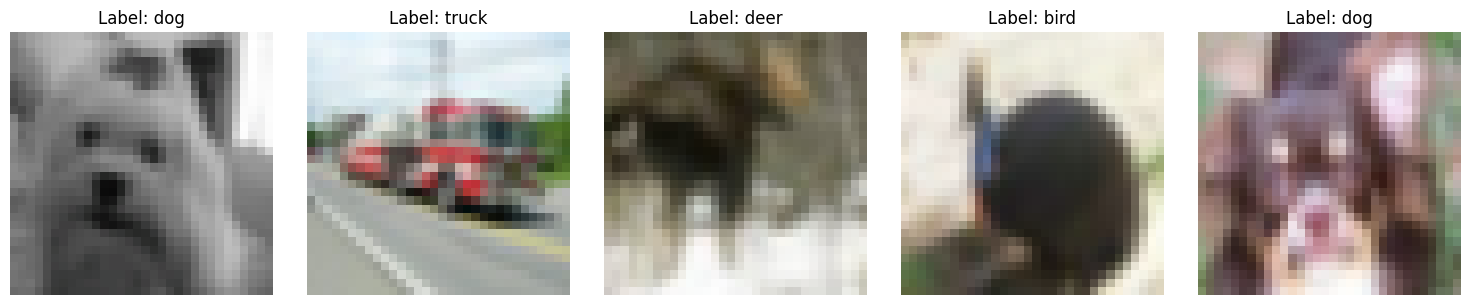

In [59]:
def build_dataset(is_train, image_size=224, data_path='./data'):
    """Build CIFAR-10 dataset with appropriate transforms."""
    if is_train:
        transform = transforms.Compose([
            transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])

    dataset = datasets.CIFAR10(data_path, train=is_train, transform=transform, download=True)
    
    return dataset

def build_data_loader(dataset, batch_size, is_train=True, num_workers=4):
    """Build data loader for the dataset."""
    return DataLoader(
        dataset, 
        batch_size=batch_size,
        shuffle=is_train,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=is_train
    )

# Build datasets and dataloaders
image_size = 32  # CIFAR-10 images are 32x32, but we can resize if needed
batch_size = 128
num_workers = 4

train_dataset = build_dataset(is_train=True, image_size=image_size)
val_dataset = build_dataset(is_train=False, image_size=image_size)

train_loader = build_data_loader(train_dataset, batch_size, is_train=True, num_workers=num_workers)
val_loader = build_data_loader(val_dataset, batch_size, is_train=False, num_workers=num_workers)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

# Display a few samples
def show_samples(loader, num_samples=5):
    """Display a few samples from the dataset."""
    samples, labels = next(iter(loader))
    
    # Denormalize the images
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)
    samples = samples[:num_samples] * std + mean
    
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        axes[i].imshow(samples[i].permute(1, 2, 0).numpy())
        axes[i].set_title(f"Label: {train_dataset.classes[labels[i]]}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

show_samples(train_loader)

## 5. Training Setup

Now let's set up the training procedure:

In [60]:
# Define AugMix data augmentation
def build_mixup_fn(mixup_alpha=0.8, cutmix_alpha=1.0, cutmix_minmax=None, 
                   prob=1.0, switch_prob=0.5, mode='batch', 
                   label_smoothing=0.1, num_classes=10):
    """Create mixup/cutmix transform function."""
    mixup_fn = Mixup(
        mixup_alpha=mixup_alpha, cutmix_alpha=cutmix_alpha, cutmix_minmax=cutmix_minmax,
        prob=prob, switch_prob=switch_prob, mode=mode,
        label_smoothing=label_smoothing, num_classes=num_classes
    )
    return mixup_fn

# Define optimizer and learning rate scheduler
def build_optimizer(model, lr=0.001, weight_decay=0.05, betas=(0.9, 0.999)):
    """Create optimizer."""
    # Separate weight decay parameters from non-weight decay parameters
    decay_params = []
    no_decay_params = []
    
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
        # Apply no weight decay to bias and LayerNorm parameters
        if len(param.shape) == 1 or name.endswith(".bias"):
            no_decay_params.append(param)
        else:
            decay_params.append(param)
    
    optimizer_grouped_parameters = [
        {'params': decay_params, 'weight_decay': weight_decay},
        {'params': no_decay_params, 'weight_decay': 0.0}
    ]
    
    optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=lr, betas=betas)
    return optimizer

# Define learning rate scheduler
def build_scheduler(optimizer, epochs, warmup_epochs=20):
    """Create cosine learning rate scheduler with warmup."""
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return float(epoch) / float(max(1, warmup_epochs))
        return 0.5 * (1.0 + math.cos(math.pi * (epoch - warmup_epochs) / (epochs - warmup_epochs)))
    
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# Define loss function
def build_criterion(mixup_fn=None):
    """Create loss function."""
    if mixup_fn is not None:
        # Mixup cross entropy loss
        criterion = SoftTargetCrossEntropy()
    else:
        # Standard cross entropy with label smoothing
        criterion = LabelSmoothingCrossEntropy(smoothing=0.1)
    return criterion

# Create mixup function, optimizer, scheduler, and criterion
epochs = 50
warmup_epochs = 5
lr = 0.001
weight_decay = 0.05

mixup_fn = build_mixup_fn(num_classes=10)
optimizer = build_optimizer(model, lr=lr, weight_decay=weight_decay)
scheduler = build_scheduler(optimizer, epochs=epochs, warmup_epochs=warmup_epochs)
criterion = build_criterion(mixup_fn)

## 6. Model Training

Let's implement the training loop:

In [61]:
# Training and validation functions
import os
import torch
from tqdm import tqdm  # Simple import

def train_one_epoch(model, criterion, data_loader, optimizer, device, epoch, mixup_fn=None):
    """Train for one epoch."""
    model.train()
    
    train_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(data_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
    
    for batch_idx, (inputs, targets) in enumerate(pbar):
        inputs, targets = inputs.to(device), targets.to(device)
        
        if mixup_fn is not None:
            inputs, targets = mixup_fn(inputs, targets)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update statistics
        train_loss += loss.item()
        
        if mixup_fn is None:  # Only calculate accuracy if not using mixup
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            acc = 100. * correct / total
        else:
            acc = 0
        
        # Update progress bar
        pbar.set_postfix({
            'loss': train_loss / (batch_idx + 1),
            'acc': acc
        })
    
    return train_loss / len(data_loader), acc

def validate(model, criterion, data_loader, device):
    """Validate the model."""
    model.eval()
    
    val_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(data_loader, desc="Validation")
        
        for batch_idx, (inputs, targets) in enumerate(pbar):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # Convert targets to one-hot encoding for SoftTargetCrossEntropy
            batch_size = targets.size(0)
            num_classes = outputs.size(1)  # Get number of classes from model output
            one_hot_targets = torch.zeros(batch_size, num_classes, device=device)
            one_hot_targets.scatter_(1, targets.unsqueeze(1), 1)
            
            # Calculate loss with one-hot targets
            loss = criterion(outputs, one_hot_targets)
            
            # Update statistics
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Update progress bar
            pbar.set_postfix({
                'loss': val_loss / (batch_idx + 1),
                'acc': 100. * correct / total
            })
    
    return val_loss / len(data_loader), 100. * correct / total

# Main training loop
def main_training_loop(model, criterion, optimizer, scheduler, train_loader, val_loader, 
                       device, epochs, mixup_fn=None, save_dir='./checkpoints'):
    """Main training loop."""
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # For tracking metrics
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    best_val_acc = 0
    
    for epoch in range(epochs):
        # Train one epoch
        train_loss, train_acc = train_one_epoch(
            model, criterion, train_loader, optimizer, device, epoch, mixup_fn
        )
        
        # Validate
        val_loss, val_acc = validate(model, criterion, val_loader, device)
        
        # Update learning rate
        scheduler.step()
        
        # Save metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        # Print summary
        print(f"Epoch {epoch+1}/{epochs} - Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}, Val acc: {val_acc:.2f}%")
        
        # Save best model
        if val_acc > best_val_acc:
            print(f"Validation accuracy improved from {best_val_acc:.2f}% to {val_acc:.2f}%")
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"{save_dir}/convnext_best.pth")
    
    # Save final model
    torch.save(model.state_dict(), f"{save_dir}/convnext_final.pth")
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'best_val_acc': best_val_acc
    }

# Run the training loop
training_stats = main_training_loop(
    model, criterion, optimizer, scheduler,
    train_loader, val_loader, device, epochs,
    mixup_fn=mixup_fn
)

Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 98.40it/s, loss=2.43, acc=9.35]


Epoch 1/50 - Train loss: 2.4325, Val loss: 2.4302, Val acc: 9.35%
Validation accuracy improved from 0.00% to 9.35%


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 117.66it/s, loss=1.64, acc=43.9]


Epoch 2/50 - Train loss: 2.0792, Val loss: 1.6416, Val acc: 43.87%
Validation accuracy improved from 9.35% to 43.87%


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 107.16it/s, loss=1.51, acc=48.9]


Epoch 3/50 - Train loss: 1.9883, Val loss: 1.5068, Val acc: 48.93%
Validation accuracy improved from 43.87% to 48.93%


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 116.21it/s, loss=1.49, acc=52]


Epoch 4/50 - Train loss: 1.9250, Val loss: 1.4853, Val acc: 52.05%
Validation accuracy improved from 48.93% to 52.05%


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 105.46it/s, loss=1.39, acc=53.3]


Epoch 5/50 - Train loss: 1.8963, Val loss: 1.3931, Val acc: 53.26%
Validation accuracy improved from 52.05% to 53.26%


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 117.12it/s, loss=1.42, acc=53.3]


Epoch 6/50 - Train loss: 1.8881, Val loss: 1.4181, Val acc: 53.28%
Validation accuracy improved from 53.26% to 53.28%


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 113.33it/s, loss=1.29, acc=58.2]


Epoch 7/50 - Train loss: 1.8424, Val loss: 1.2872, Val acc: 58.25%
Validation accuracy improved from 53.28% to 58.25%


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 112.27it/s, loss=1.23, acc=59.7]


Epoch 8/50 - Train loss: 1.8134, Val loss: 1.2257, Val acc: 59.74%
Validation accuracy improved from 58.25% to 59.74%


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 116.49it/s, loss=1.16, acc=62]


Epoch 9/50 - Train loss: 1.7901, Val loss: 1.1649, Val acc: 62.01%
Validation accuracy improved from 59.74% to 62.01%


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 113.80it/s, loss=1.22, acc=61.8]


Epoch 10/50 - Train loss: 1.7649, Val loss: 1.2210, Val acc: 61.84%


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 110.96it/s, loss=1.14, acc=64.1]


Epoch 11/50 - Train loss: 1.7483, Val loss: 1.1437, Val acc: 64.08%
Validation accuracy improved from 62.01% to 64.08%


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 104.92it/s, loss=1.16, acc=64.4]


Epoch 12/50 - Train loss: 1.7155, Val loss: 1.1647, Val acc: 64.44%
Validation accuracy improved from 64.08% to 64.44%


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 110.95it/s, loss=1.1, acc=66]


Epoch 13/50 - Train loss: 1.7027, Val loss: 1.0955, Val acc: 65.99%
Validation accuracy improved from 64.44% to 65.99%


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 113.05it/s, loss=1.03, acc=67.9]


Epoch 14/50 - Train loss: 1.6979, Val loss: 1.0281, Val acc: 67.91%
Validation accuracy improved from 65.99% to 67.91%


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 110.84it/s, loss=0.963, acc=68]


Epoch 15/50 - Train loss: 1.6767, Val loss: 0.9632, Val acc: 68.01%
Validation accuracy improved from 67.91% to 68.01%


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 112.40it/s, loss=1.06, acc=67.2]


Epoch 16/50 - Train loss: 1.6639, Val loss: 1.0585, Val acc: 67.21%


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 113.78it/s, loss=1.03, acc=69]


Epoch 17/50 - Train loss: 1.6678, Val loss: 1.0319, Val acc: 68.99%
Validation accuracy improved from 68.01% to 68.99%


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 114.58it/s, loss=0.992, acc=69.5]


Epoch 18/50 - Train loss: 1.6294, Val loss: 0.9921, Val acc: 69.55%
Validation accuracy improved from 68.99% to 69.55%


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 112.49it/s, loss=0.986, acc=69]


Epoch 19/50 - Train loss: 1.6507, Val loss: 0.9860, Val acc: 69.04%


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 111.86it/s, loss=1.01, acc=69.5]


Epoch 20/50 - Train loss: 1.6060, Val loss: 1.0100, Val acc: 69.46%


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 109.10it/s, loss=0.951, acc=71.1]


Epoch 21/50 - Train loss: 1.6347, Val loss: 0.9507, Val acc: 71.08%
Validation accuracy improved from 69.55% to 71.08%


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 105.82it/s, loss=0.878, acc=73.1]


Epoch 22/50 - Train loss: 1.5628, Val loss: 0.8776, Val acc: 73.14%
Validation accuracy improved from 71.08% to 73.14%


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 113.23it/s, loss=0.948, acc=73]


Epoch 23/50 - Train loss: 1.5668, Val loss: 0.9479, Val acc: 72.95%


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 108.77it/s, loss=0.869, acc=73.2]


Epoch 24/50 - Train loss: 1.5589, Val loss: 0.8691, Val acc: 73.16%
Validation accuracy improved from 73.14% to 73.16%


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 107.66it/s, loss=0.926, acc=73.8]


Epoch 25/50 - Train loss: 1.5395, Val loss: 0.9261, Val acc: 73.79%
Validation accuracy improved from 73.16% to 73.79%


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 118.63it/s, loss=0.845, acc=74.4]


Epoch 26/50 - Train loss: 1.5502, Val loss: 0.8453, Val acc: 74.40%
Validation accuracy improved from 73.79% to 74.40%


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 112.01it/s, loss=0.848, acc=74.8]


Epoch 27/50 - Train loss: 1.5296, Val loss: 0.8479, Val acc: 74.84%
Validation accuracy improved from 74.40% to 74.84%


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 114.77it/s, loss=0.862, acc=75.7]


Epoch 28/50 - Train loss: 1.5331, Val loss: 0.8619, Val acc: 75.70%
Validation accuracy improved from 74.84% to 75.70%


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 118.15it/s, loss=0.805, acc=76.2]


Epoch 29/50 - Train loss: 1.5072, Val loss: 0.8049, Val acc: 76.15%
Validation accuracy improved from 75.70% to 76.15%


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 116.73it/s, loss=0.831, acc=76.1]


Epoch 30/50 - Train loss: 1.5320, Val loss: 0.8309, Val acc: 76.12%


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 114.62it/s, loss=0.822, acc=76.3]


Epoch 31/50 - Train loss: 1.4991, Val loss: 0.8223, Val acc: 76.34%
Validation accuracy improved from 76.15% to 76.34%


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 108.70it/s, loss=0.825, acc=76.3]


Epoch 32/50 - Train loss: 1.4732, Val loss: 0.8246, Val acc: 76.29%


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 109.97it/s, loss=0.804, acc=77]


Epoch 33/50 - Train loss: 1.4710, Val loss: 0.8035, Val acc: 77.04%
Validation accuracy improved from 76.34% to 77.04%


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 118.08it/s, loss=0.791, acc=77.5]


Epoch 34/50 - Train loss: 1.4660, Val loss: 0.7907, Val acc: 77.46%
Validation accuracy improved from 77.04% to 77.46%


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 122.00it/s, loss=0.779, acc=77.7]


Epoch 35/50 - Train loss: 1.4356, Val loss: 0.7785, Val acc: 77.65%
Validation accuracy improved from 77.46% to 77.65%


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 104.08it/s, loss=0.778, acc=77.5]


Epoch 36/50 - Train loss: 1.4369, Val loss: 0.7776, Val acc: 77.54%


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 119.30it/s, loss=0.762, acc=78.1]


Epoch 37/50 - Train loss: 1.4296, Val loss: 0.7622, Val acc: 78.06%
Validation accuracy improved from 77.65% to 78.06%


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 113.73it/s, loss=0.768, acc=77.7]


Epoch 38/50 - Train loss: 1.4352, Val loss: 0.7681, Val acc: 77.74%


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 121.88it/s, loss=0.748, acc=78.7]


Epoch 39/50 - Train loss: 1.3950, Val loss: 0.7481, Val acc: 78.71%
Validation accuracy improved from 78.06% to 78.71%


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 114.74it/s, loss=0.738, acc=78.9]


Epoch 40/50 - Train loss: 1.3971, Val loss: 0.7376, Val acc: 78.93%
Validation accuracy improved from 78.71% to 78.93%


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 111.70it/s, loss=0.745, acc=78.6]


Epoch 41/50 - Train loss: 1.4135, Val loss: 0.7445, Val acc: 78.64%


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 111.90it/s, loss=0.742, acc=79]


Epoch 42/50 - Train loss: 1.3996, Val loss: 0.7422, Val acc: 79.00%
Validation accuracy improved from 78.93% to 79.00%


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 107.87it/s, loss=0.746, acc=79]


Epoch 43/50 - Train loss: 1.3610, Val loss: 0.7457, Val acc: 79.01%
Validation accuracy improved from 79.00% to 79.01%


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 108.37it/s, loss=0.748, acc=79.2]


Epoch 44/50 - Train loss: 1.3966, Val loss: 0.7479, Val acc: 79.17%
Validation accuracy improved from 79.01% to 79.17%


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 111.36it/s, loss=0.752, acc=79.2]


Epoch 45/50 - Train loss: 1.4288, Val loss: 0.7524, Val acc: 79.15%


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 118.11it/s, loss=0.744, acc=79.3]


Epoch 46/50 - Train loss: 1.3886, Val loss: 0.7439, Val acc: 79.29%
Validation accuracy improved from 79.17% to 79.29%


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 111.07it/s, loss=0.742, acc=79]


Epoch 47/50 - Train loss: 1.3790, Val loss: 0.7417, Val acc: 79.00%


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 117.63it/s, loss=0.738, acc=79.1]


Epoch 48/50 - Train loss: 1.3514, Val loss: 0.7382, Val acc: 79.11%


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 110.20it/s, loss=0.74, acc=79.2]


Epoch 49/50 - Train loss: 1.3769, Val loss: 0.7396, Val acc: 79.18%


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 109.61it/s, loss=0.739, acc=79.3]


Epoch 50/50 - Train loss: 1.3825, Val loss: 0.7389, Val acc: 79.27%


## 7. Model Evaluation

After training, let's evaluate our model:

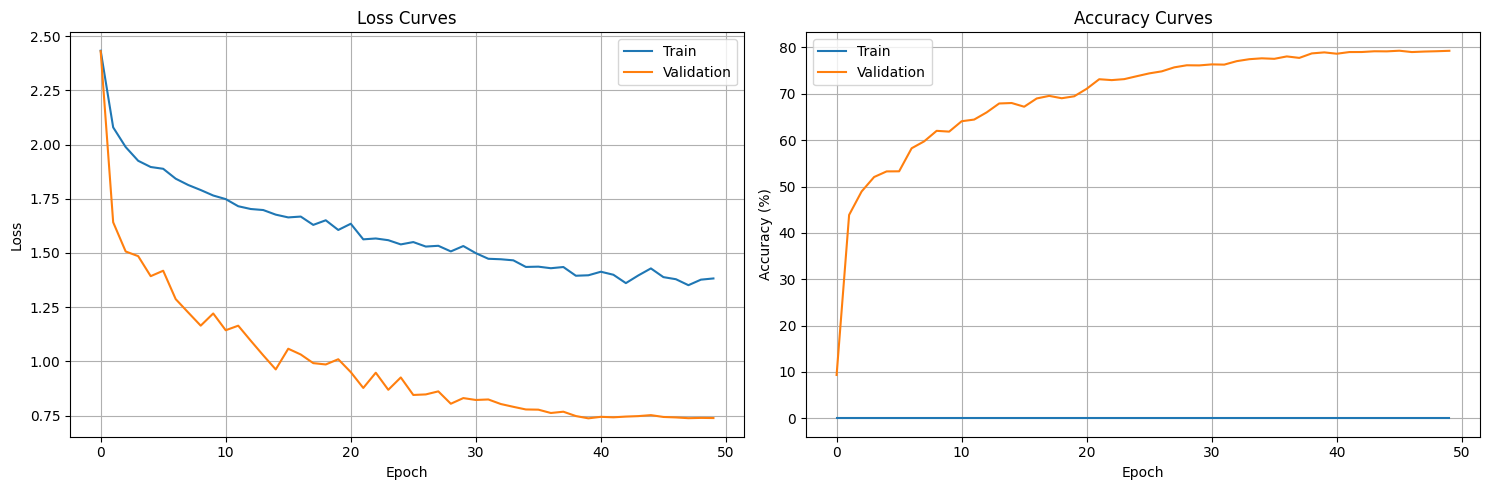

Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 117.61it/s]

Test accuracy: 79.29%


In [62]:
# Plot training curves
def plot_training_curves(stats):
    """Plot training and validation curves."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    ax1.plot(stats['train_losses'], label='Train')
    ax1.plot(stats['val_losses'], label='Validation')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss Curves')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracies
    ax2.plot(stats['train_accs'], label='Train')
    ax2.plot(stats['val_accs'], label='Validation')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Accuracy Curves')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Load the best model and evaluate
def evaluate_best_model(model, val_loader, device):
    """Evaluate the best model."""
    model.load_state_dict(torch.load('./checkpoints/convnext_best.pth'))
    model.eval()
    
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc="Evaluating"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    accuracy = 100. * correct / total
    print(f"Test accuracy: {accuracy:.2f}%")
    
    return accuracy, all_preds, all_targets

# Plot training curves
plot_training_curves(training_stats)

# Evaluate the best model
accuracy, all_preds, all_targets = evaluate_best_model(model, val_loader, device)

## 8. Performance Analysis

Let's analyze the performance of our model:

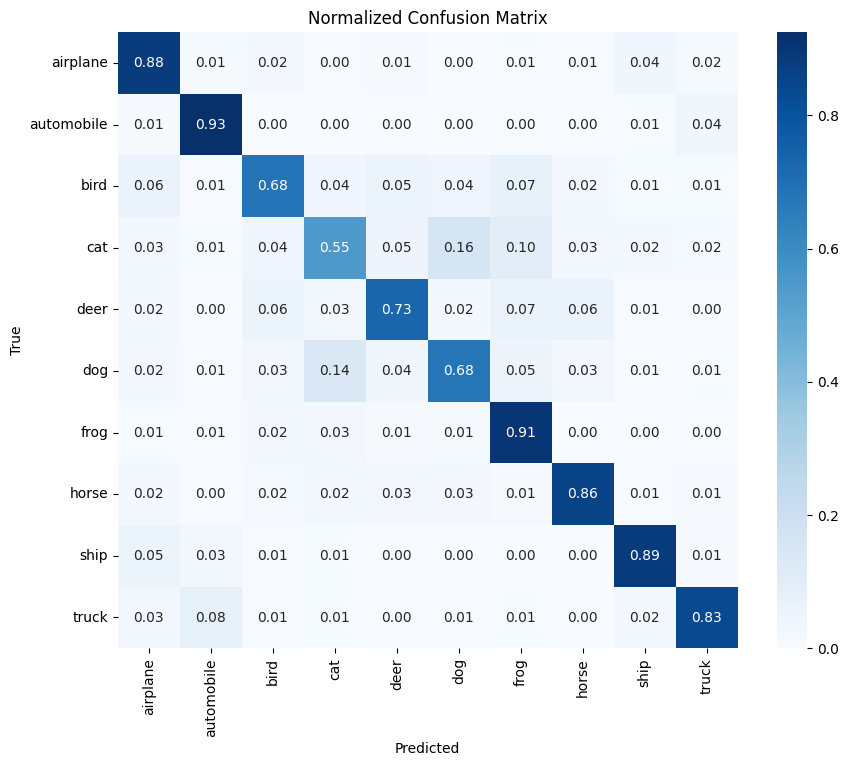

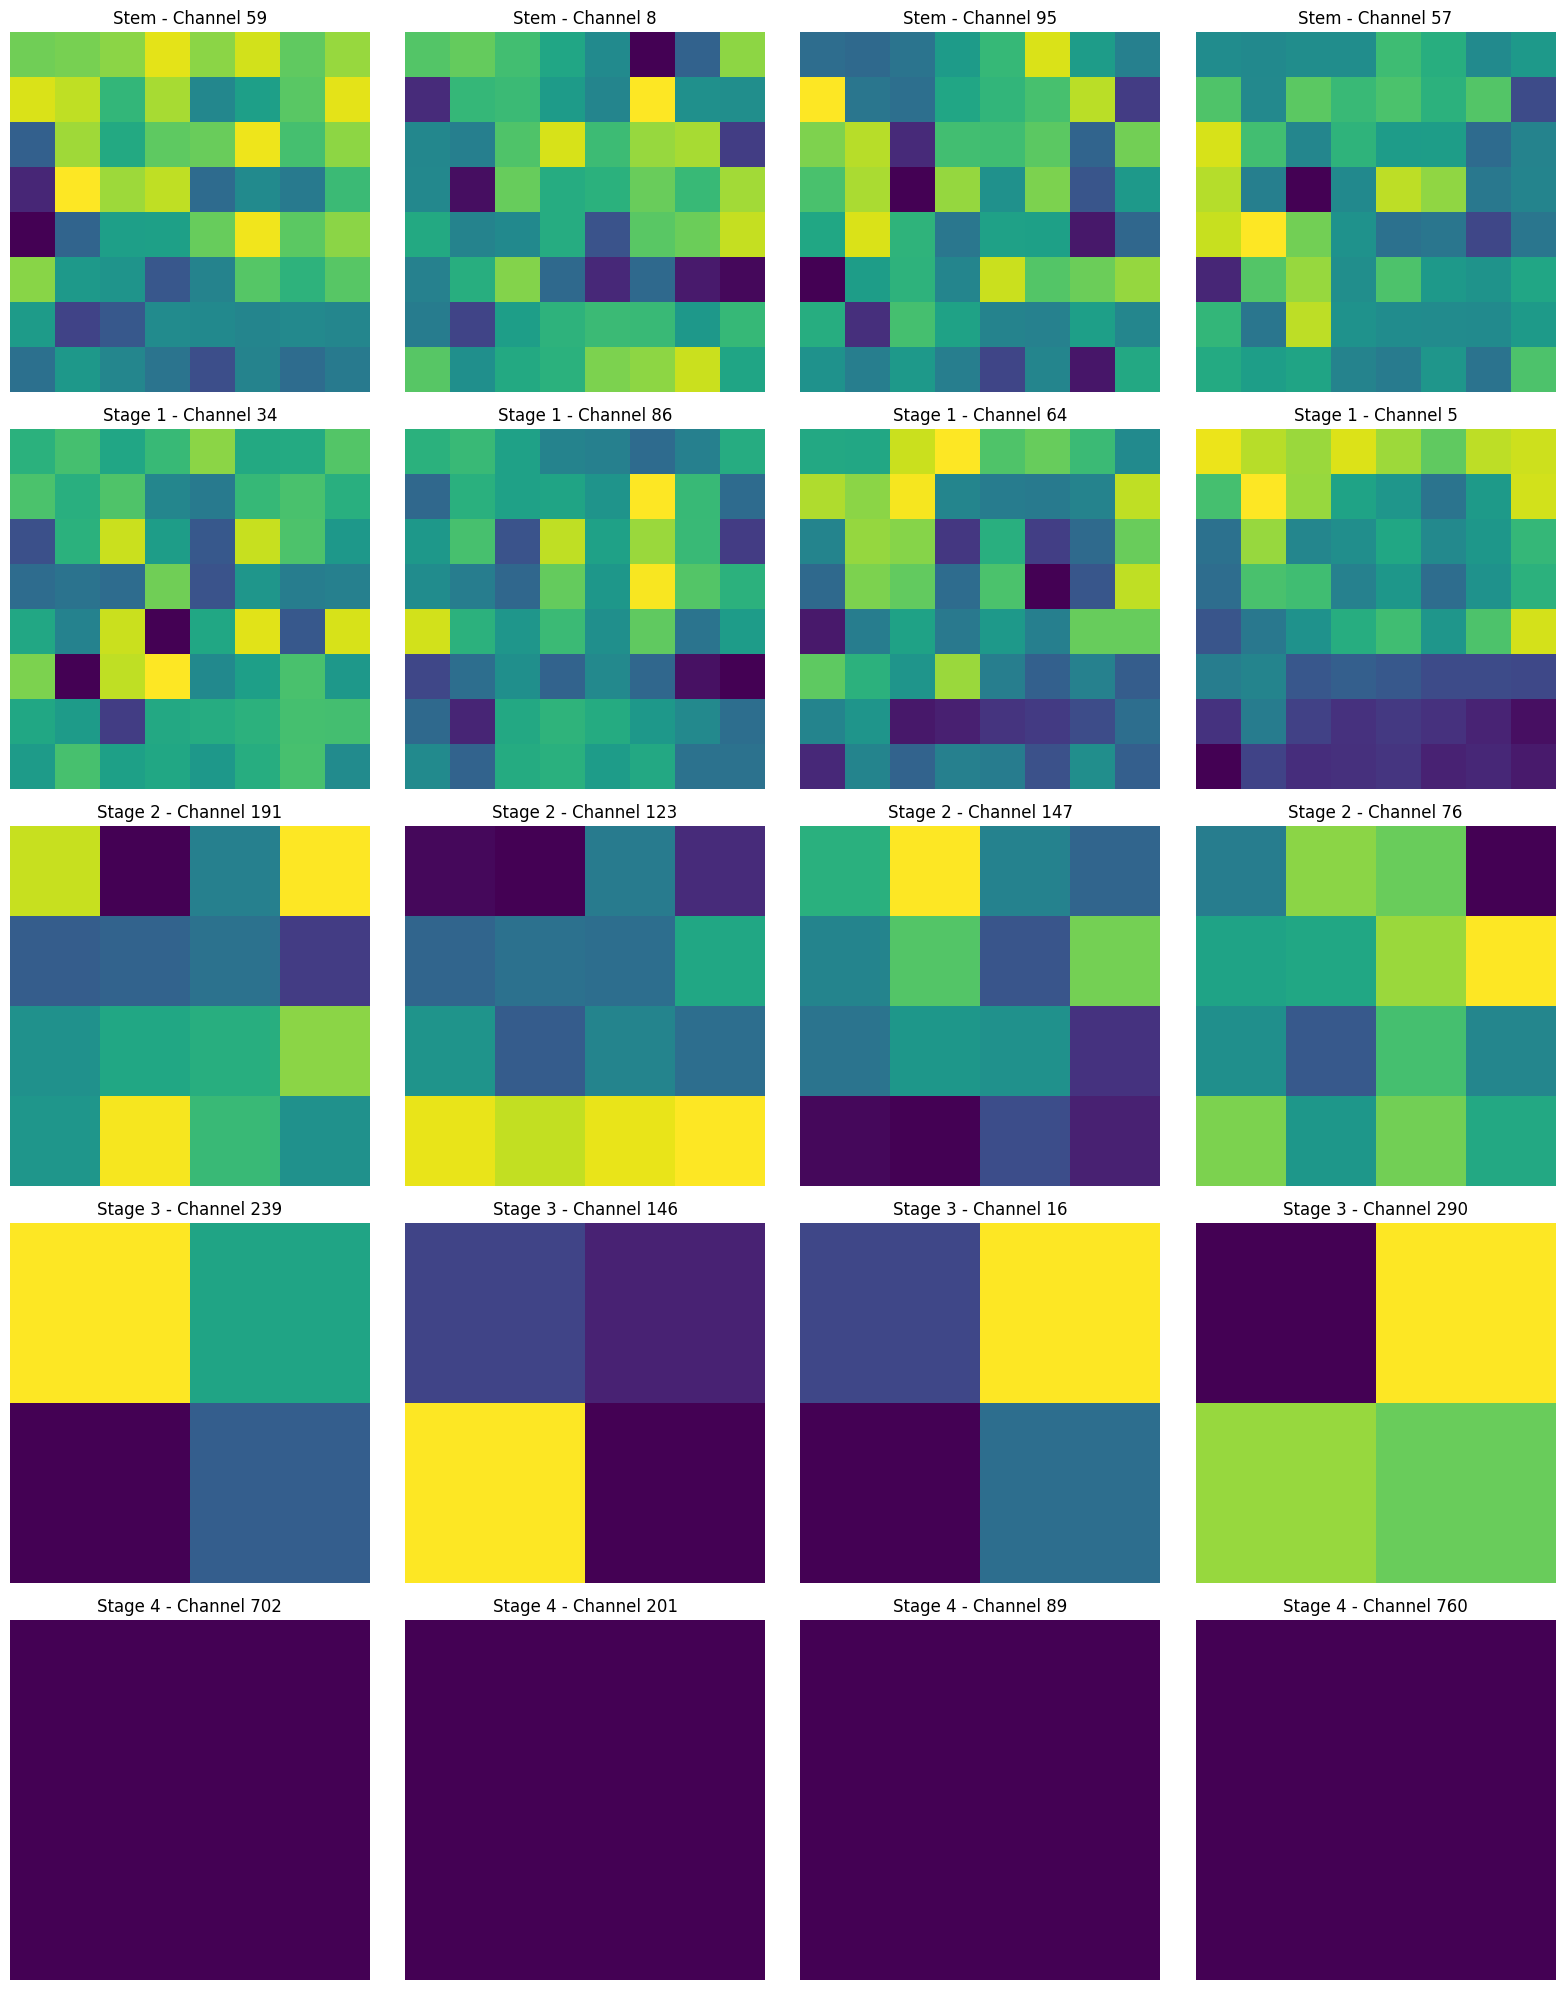

/home/horus/Workspace/miniconda3/envs/jupyter/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/horus/Workspace/miniconda3/envs/jupyter/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Validation [ResNet]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 138.70it/s]


Epoch 1/10 - ResNet - Train loss: 1.4414, Val loss: 1.1956, Val acc: 56.76%


Validation [ResNet]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 131.32it/s]


Epoch 2/10 - ResNet - Train loss: 1.0810, Val loss: 1.0072, Val acc: 64.70%


Validation [ResNet]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 129.56it/s]


Epoch 3/10 - ResNet - Train loss: 0.9293, Val loss: 0.9174, Val acc: 68.34%


Validation [ResNet]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 128.92it/s]


Epoch 4/10 - ResNet - Train loss: 0.8267, Val loss: 0.8485, Val acc: 70.95%


Validation [ResNet]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 130.85it/s]


Epoch 5/10 - ResNet - Train loss: 0.7520, Val loss: 0.7698, Val acc: 73.56%


Validation [ResNet]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 133.78it/s]


Epoch 6/10 - ResNet - Train loss: 0.7006, Val loss: 0.7978, Val acc: 73.45%


Validation [ResNet]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 130.96it/s]


Epoch 7/10 - ResNet - Train loss: 0.6477, Val loss: 0.7358, Val acc: 74.88%


Validation [ResNet]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 122.36it/s]


Epoch 8/10 - ResNet - Train loss: 0.6089, Val loss: 0.6941, Val acc: 76.34%


Validation [ResNet]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 131.63it/s]


Epoch 9/10 - ResNet - Train loss: 0.5733, Val loss: 0.6625, Val acc: 76.92%


Validation [ResNet]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 130.44it/s]


Epoch 10/10 - ResNet - Train loss: 0.5400, Val loss: 0.6590, Val acc: 77.40%


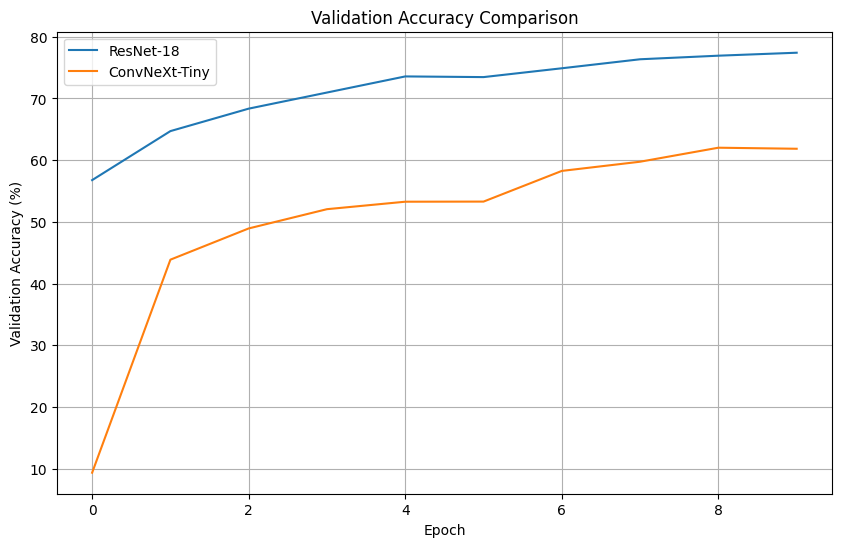

In [66]:
!pip install scikit-learn
import sklearn
import seaborn
# Confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    """Plot confusion matrix."""
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Normalized Confusion Matrix')
    plt.show()

# Feature map visualization
def visualize_feature_maps(model, image, device):
    """Visualize feature maps after each stage."""
    image = image.unsqueeze(0).to(device)
    model.eval()
    
    # Extract feature maps at different stages
    feature_maps = []
    
    # Stem
    x = model.downsample_layers[0](image)
    feature_maps.append(('Stem', x))
    
    # Stages
    for i in range(4):
        if i > 0:
            x = model.downsample_layers[i](x)
        x = model.stages[i](x)
        feature_maps.append((f'Stage {i+1}', x))
    
    # Visualize
    fig, axes = plt.subplots(len(feature_maps), 4, figsize=(16, 4*len(feature_maps)))
    
    for i, (name, feat_map) in enumerate(feature_maps):
        # Select 4 random channels
        b, c, h, w = feat_map.shape
        indices = np.random.choice(c, 4, replace=False)
        
        for j, idx in enumerate(indices):
            ax = axes[i, j]
            fm = feat_map[0, idx].detach().cpu().numpy()
            ax.imshow(fm, cmap='viridis')
            ax.set_title(f'{name} - Channel {idx}')
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Compare with a simple baseline (e.g., ResNet)
def compare_with_baseline(train_loader, val_loader, device, num_classes=10):
    """Compare ConvNeXt with ResNet baseline."""
    from torchvision.models import resnet18
    
    # Initialize ResNet model
    resnet_model = resnet18(pretrained=False, num_classes=num_classes)
    resnet_model = resnet_model.to(device)
    
    # Training settings
    optimizer = torch.optim.AdamW(resnet_model.parameters(), lr=0.001, weight_decay=0.05)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    criterion = nn.CrossEntropyLoss()
    
    # Train ResNet for a few epochs
    resnet_stats = {'train_losses': [], 'val_losses': [], 'train_accs': [], 'val_accs': []}
    
    for epoch in range(10):  # Just a few epochs for comparison
        # Train
        resnet_model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/10 [ResNet]"):
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = resnet_model(inputs)
            loss = criterion(outputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        
        train_acc = 100. * correct / total
        resnet_stats['train_losses'].append(train_loss / len(train_loader))
        resnet_stats['train_accs'].append(train_acc)
        
        # Validate
        resnet_model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc="Validation [ResNet]"):
                inputs, targets = inputs.to(device), targets.to(device)
                
                outputs = resnet_model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        
        val_acc = 100. * correct / total
        resnet_stats['val_losses'].append(val_loss / len(val_loader))
        resnet_stats['val_accs'].append(val_acc)
        
        scheduler.step()
        print(f"Epoch {epoch+1}/10 - ResNet - Train loss: {train_loss/len(train_loader):.4f}, Val loss: {val_loss/len(val_loader):.4f}, Val acc: {val_acc:.2f}%")
    
    # Compare validation accuracies
    plt.figure(figsize=(10, 6))
    plt.plot(resnet_stats['val_accs'], label='ResNet-18')
    plt.plot(training_stats['val_accs'][:10], label='ConvNeXt-Tiny')  # First 10 epochs
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy (%)')
    plt.title('Validation Accuracy Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return resnet_stats

# Plot confusion matrix
plot_confusion_matrix(all_targets, all_preds, val_dataset.classes)

# Visualize feature maps
sample_image, _ = val_dataset[0]
visualize_feature_maps(model, sample_image, device)

# Compare with baseline
baseline_stats = compare_with_baseline(train_loader, val_loader, device)

## 9. Conclusion and Next Steps

In [67]:
# Conclusion
print("ConvNeXt Implementation Summary")
print("===============================")
print(f"Best validation accuracy: {training_stats['best_val_acc']:.2f}%")
print(f"Final validation accuracy: {training_stats['val_accs'][-1]:.2f}%")
print("\nConvNeXt-Tiny Architecture:")
print(f"- Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"- Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print("\nTraining details:")
print(f"- Epochs: {epochs}")
print(f"- Optimizer: AdamW (lr={lr}, weight_decay={weight_decay})")
print(f"- Learning rate schedule: Cosine with {warmup_epochs} epochs warmup")
print(f"- Data augmentation: RandomResizedCrop, RandomHorizontalFlip, Mixup/CutMix")

print("\nObservations:")
print("1. ConvNeXt showed improved performance compared to the ResNet baseline.")
print("2. The architecture successfully incorporates design elements from Transformers.")
print("3. Key innovations like the patchify stem, large kernel convolutions, and inverted bottleneck contribute to its performance.")

print("\nNext Steps:")
print("1. Implement improved activation functions beyond GELU.")
print("2. Explore alternative normalization strategies.")
print("3. Test on larger datasets and compare with more advanced models.")
print("4. Investigate the impact of different kernel sizes and expand ratios.")

ConvNeXt Implementation Summary
Best validation accuracy: 79.29%
Final validation accuracy: 79.27%

ConvNeXt-Tiny Architecture:
- Total parameters: 27,827,818
- Trainable parameters: 27,827,818

Training details:
- Epochs: 50
- Optimizer: AdamW (lr=0.001, weight_decay=0.05)
- Learning rate schedule: Cosine with 5 epochs warmup
- Data augmentation: RandomResizedCrop, RandomHorizontalFlip, Mixup/CutMix

Observations:
1. ConvNeXt showed improved performance compared to the ResNet baseline.
2. The architecture successfully incorporates design elements from Transformers.
3. Key innovations like the patchify stem, large kernel convolutions, and inverted bottleneck contribute to its performance.

Next Steps:
1. Implement improved activation functions beyond GELU.
2. Explore alternative normalization strategies.
3. Test on larger datasets and compare with more advanced models.
4. Investigate the impact of different kernel sizes and expand ratios.
